# SiamFC

Fully Convolutional Siamese Network를 구성하여 두 이미지 (size가 다른) 사이의 correlation(Similarity)을 파악하는 컨셉이다.

이를 위해 cross  correlation 작업을 거치는데 이는 어떤 object가 포함된 이미지(exemplar image)를 다른 이미지(larger search image)에 대해 sliding window로서 사용한다.

cross correlation은 각각 sliding window 작업에서 내적을 하는 것과 같음. 즉 선형적 관계성을 표현할 수 있다.

그래서 해당 object가 어떤 이미지에 있을 때 그 이미지에 대해 cross correlation을 적용하면 그 object가 있는 위치에 값이 크게 나오게 된다.!!



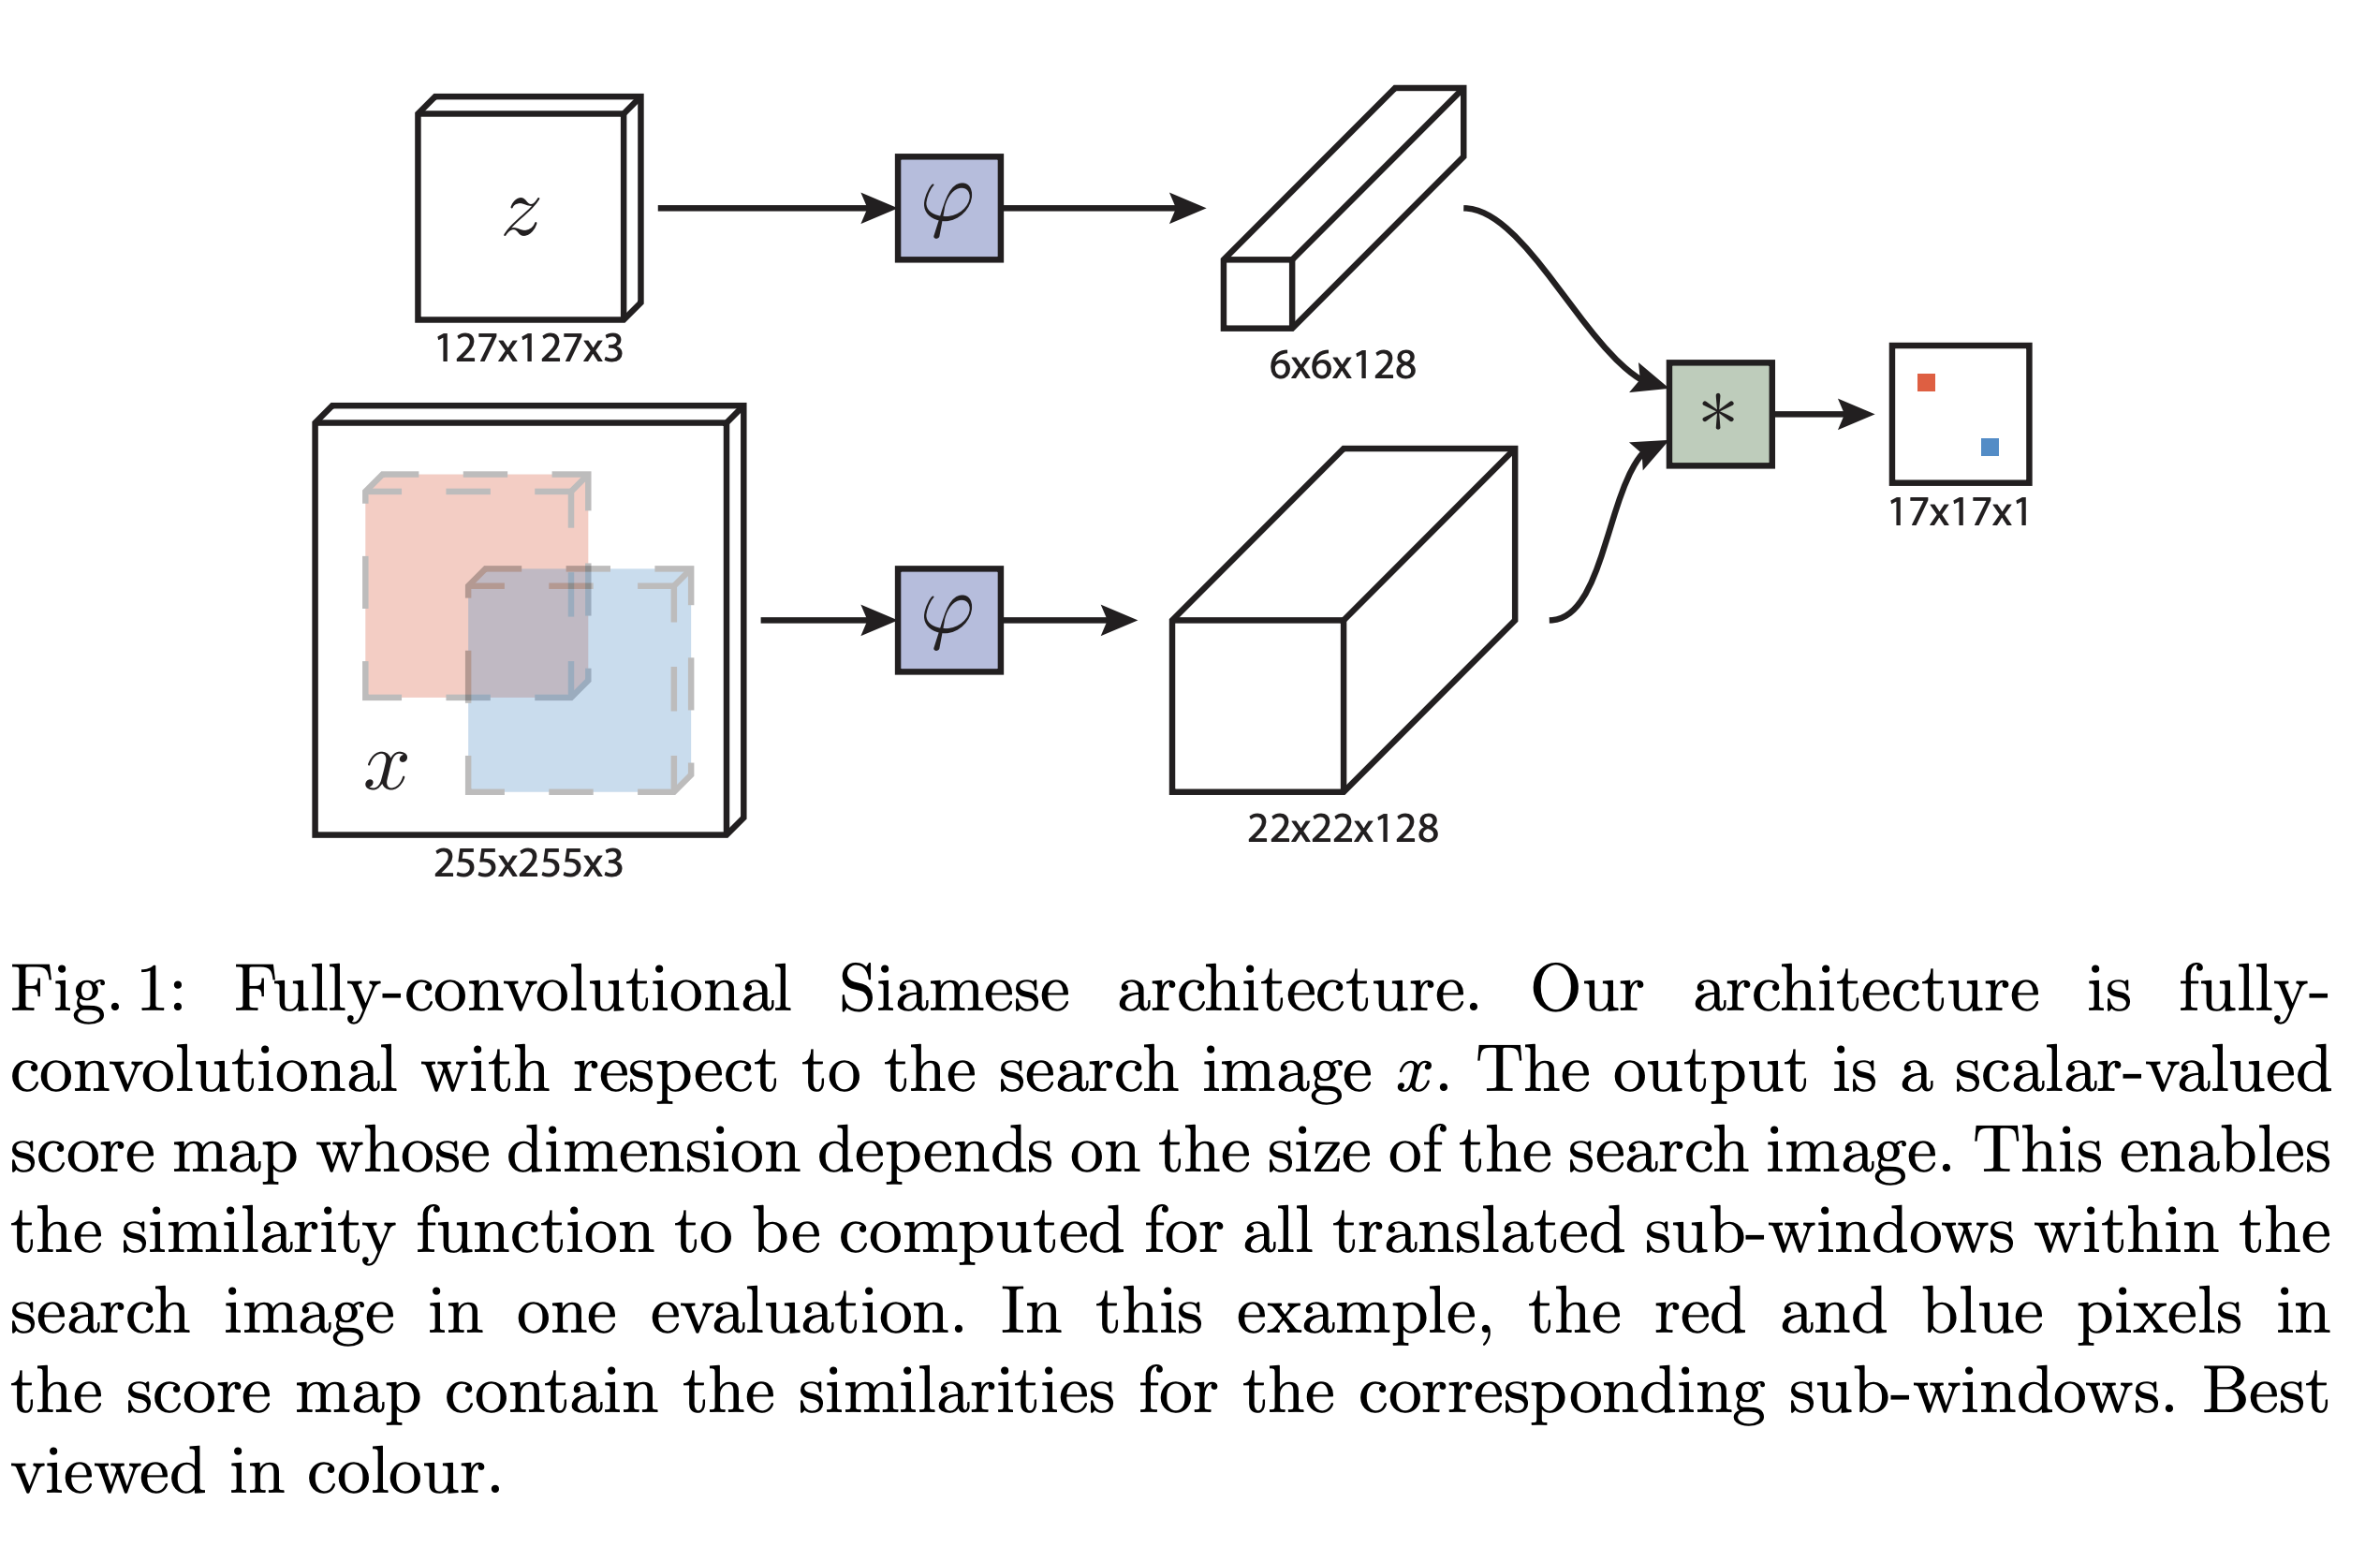

동일한 backbone cnn을 사용하여 exemplar image와 search image 둘다 embedding 시켜주고, 이에 대한 output인 feature map들을 cross correlation 시켜서 search image 내의 exemplar object를 찾아준다.

## Utils

In [ ]:
import torch.nn as nn
import cv2
import numpy as np


def init_weights(model, gain=1): # Weighs initialization
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def read_image(img_file, cvt_code=cv2.COLOR_BGR2RGB):
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    if cvt_code is not None:
        img = cv2.cvtColor(img, cvt_code)
    return img


def show_image(img, boxes=None, box_fmt='ltwh', colors=None,
               thickness=3, fig_n=1, delay=1, visualize=True,
               cvt_code=cv2.COLOR_RGB2BGR):
    if cvt_code is not None:
        img = cv2.cvtColor(img, cvt_code)
    
    # resize img if necessary
    max_size = 960
    if max(img.shape[:2]) > max_size:
        scale = max_size / max(img.shape[:2])
        out_size = (
            int(img.shape[1] * scale),
            int(img.shape[0] * scale))
        img = cv2.resize(img, out_size)
        if boxes is not None:
            boxes = np.array(boxes, dtype=np.float32) * scale
    
    if boxes is not None:
        assert box_fmt in ['ltwh', 'ltrb']
        boxes = np.array(boxes, dtype=np.int32)
        if boxes.ndim == 1:
            boxes = np.expand_dims(boxes, axis=0)
        if box_fmt == 'ltrb':
            boxes[:, 2:] -= boxes[:, :2]
        
        # clip bounding boxes
        bound = np.array(img.shape[1::-1])[None, :]
        boxes[:, :2] = np.clip(boxes[:, :2], 0, bound)
        boxes[:, 2:] = np.clip(boxes[:, 2:], 0, bound - boxes[:, :2])
        
        if colors is None:
            colors = [
                (0, 0, 255),
                (0, 255, 0),
                (255, 0, 0),
                (0, 255, 255),
                (255, 0, 255),
                (255, 255, 0),
                (0, 0, 128),
                (0, 128, 0),
                (128, 0, 0),
                (0, 128, 128),
                (128, 0, 128),
                (128, 128, 0)]
        colors = np.array(colors, dtype=np.int32)
        if colors.ndim == 1:
            colors = np.expand_dims(colors, axis=0)
        
        for i, box in enumerate(boxes):
            color = colors[i % len(colors)]
            pt1 = (box[0], box[1])
            pt2 = (box[0] + box[2], box[1] + box[3])
            img = cv2.rectangle(img, pt1, pt2, color.tolist(), thickness)
    
    if visualize:
        winname = 'window_{}'.format(fig_n)
        cv2.imshow(winname, img)
        cv2.waitKey(delay)

    return img


# Crop and Resize. (자르고 resize해준다.)
def crop_and_resize(img, center, size, out_size,
                    border_type=cv2.BORDER_CONSTANT,
                    border_value=(0, 0, 0),
                    interp=cv2.INTER_LINEAR):
    # convert box to corners (0-indexed)
    size = round(size)
    corners = np.concatenate((
        np.round(center - (size - 1) / 2),
        np.round(center - (size - 1) / 2) + size))
    corners = np.round(corners).astype(int)
    # corner 구함.
    # pad image if necessary
    pads = np.concatenate((
        -corners[:2], corners[2:] - img.shape[:2]))
    npad = max(0, int(pads.max()))
    if npad > 0:
        img = cv2.copyMakeBorder(
            img, npad, npad, npad, npad,
            border_type, value=border_value)

    # crop image patch
    corners = (corners + npad).astype(int)
    patch = img[corners[0]:corners[2], corners[1]:corners[3]]

    # resize to out_size
    patch = cv2.resize(patch, (out_size, out_size),
                       interpolation=interp)

    return patch


# Dataset 구성

데이터를 받아올 때 동일한 이미지를 두개로 해서 각 exemplar, search image로 사용한다.

이미지를 가져올 때 bbox에 대한 정보가 있는데 이를 기준으로 가운데로 놓고 각 원하는 이미지 크기로 만든다. (padding을 넣어준다던지 하는 방법으로)

코드 상에서는 search image를 구하는 과정과 exemplar image를 구하는법은 거의 같지만, 기본적으로 larger search image를 구할 때 bbox를 가운데로 두고 이미지를 패딩같은 과정을 통해 내가 원하는 이미지 크기대로 맞춰준다.

exemplar 이미지를 구할 때는 search image를 구할 때와 동일한 과정에, object bbox에 대해 좀 더 tight한 데이터여야해서 CenterCrop을 사용하여 한번 더 잘라준다.

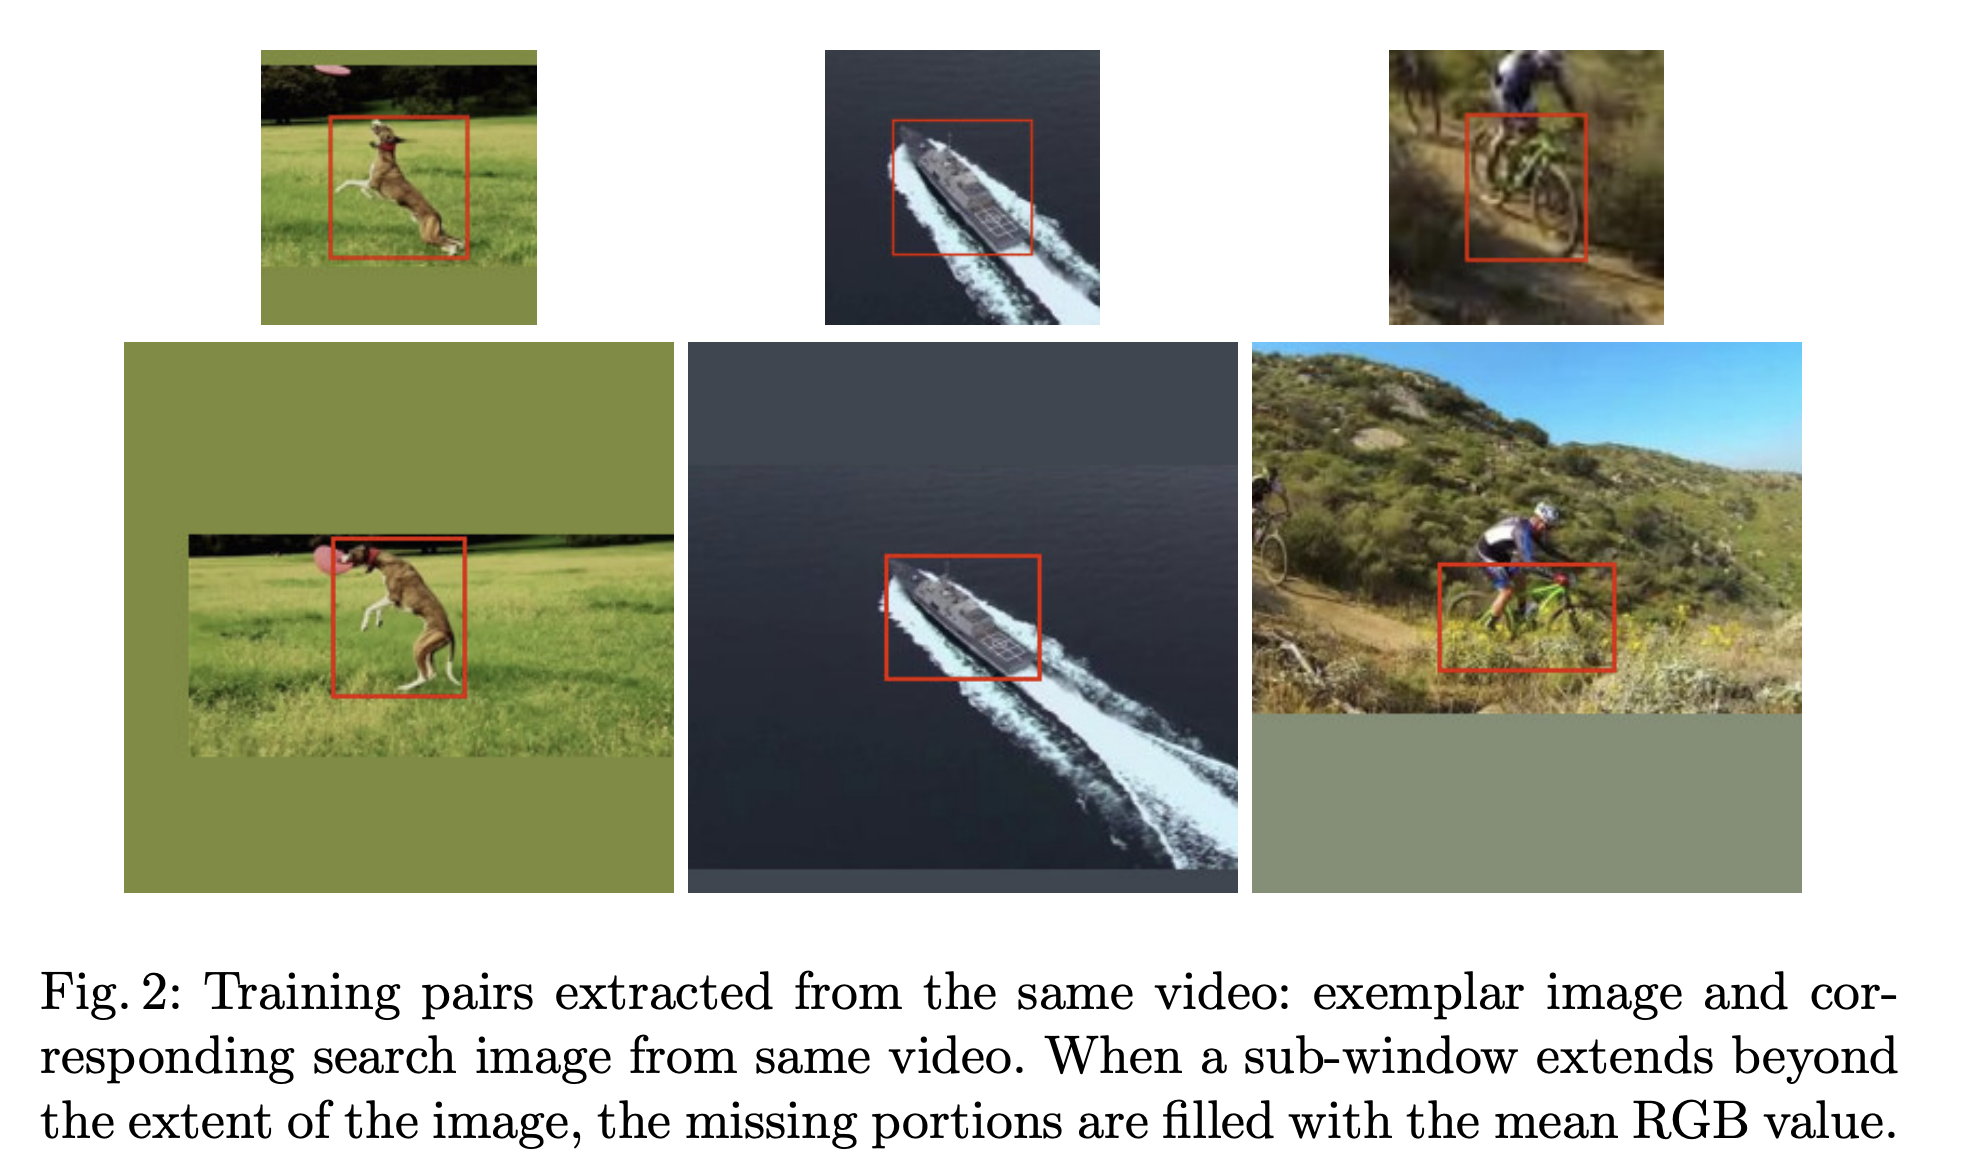

## Transforms

Transform 에서 CenterCrop 외의 다른 Transformation은 굉장히 소심하게 들어간다.
bbox의 위치가 흔들리면 안되니까!

In [ ]:
import cv2
import numpy as np
import numbers
import torch



__all__ = ['SiamFCTransforms']


class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


class RandomStretch(object):

    def __init__(self, max_stretch=0.05):
        self.max_stretch = max_stretch
    
    def __call__(self, img):
        interp = np.random.choice([
            cv2.INTER_LINEAR,
            cv2.INTER_CUBIC,
            cv2.INTER_AREA,
            cv2.INTER_NEAREST,
            cv2.INTER_LANCZOS4])
        scale = 1.0 + np.random.uniform(
            -self.max_stretch, self.max_stretch)
        out_size = (
            round(img.shape[1] * scale),
            round(img.shape[0] * scale))
        return cv2.resize(img, out_size, interpolation=interp)


class CenterCrop(object):

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
    
    def __call__(self, img):
        h, w = img.shape[:2]
        tw, th = self.size
        i = round((h - th) / 2.)
        j = round((w - tw) / 2.)

        npad = max(0, -i, -j)
        if npad > 0:
            avg_color = np.mean(img, axis=(0, 1))
            img = cv2.copyMakeBorder(
                img, npad, npad, npad, npad,
                cv2.BORDER_CONSTANT, value=avg_color)
            i += npad
            j += npad

        return img[i:i + th, j:j + tw]


class RandomCrop(object):

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
    
    def __call__(self, img):
        h, w = img.shape[:2]
        tw, th = self.size
        i = np.random.randint(0, h - th + 1)
        j = np.random.randint(0, w - tw + 1)
        return img[i:i + th, j:j + tw]


class ToTensor(object):

    def __call__(self, img):
        return torch.from_numpy(img).float().permute((2, 0, 1))


class SiamFCTransforms(object):
    # Pair는 한 img, class를 두개로 pair로 받아온다. 그래서 이에 대해서 transforms 시켜준다. exemplar의 경우에는 127 크기로 center crop,
    def __init__(self, exemplar_sz=127, instance_sz=255, context=0.5):
        self.exemplar_sz = exemplar_sz
        self.instance_sz = instance_sz
        self.context = context

        self.transforms_z = Compose([
            RandomStretch(), # 보면 random crop 이런게 아주 소심하게 자른다
            CenterCrop(instance_sz - 8), # 255-8 = 247
            RandomCrop(instance_sz - 2 * 8), # 239
            CenterCrop(exemplar_sz), # 127
            ToTensor()])
        self.transforms_x = Compose([
            RandomStretch(),
            CenterCrop(instance_sz - 8),
            RandomCrop(instance_sz - 2 * 8),
            ToTensor()])
    
    def __call__(self, z, x, box_z, box_x): # 똑같은 친구들임. 두개 다.
        # image를 받아오면 일단 크기에 맞게 crop 해준다. bbox도 마찬가지로
        z = self._crop(z, box_z, self.instance_sz)
        x = self._crop(x, box_x, self.instance_sz)
        z = self.transforms_z(z)
        x = self.transforms_x(x)
        return z, x
    
    def _crop(self, img, box, out_size): # bounding box가 가운데로 가도록 image 자체를 수정한다.
        # convert box to 0-indexed and center based [y, x, h, w] format 맞추기.
        box = np.array([
            box[1] - 1 + (box[3] - 1) / 2,
            box[0] - 1 + (box[2] - 1) / 2,
            box[3], box[2]], dtype=np.float32)
        center, target_sz = box[:2], box[2:]

        context = self.context * np.sum(target_sz) # context : margin
        size = np.sqrt(np.prod(target_sz + context))
        size *= out_size / self.exemplar_sz

        avg_color = np.mean(img, axis=(0, 1), dtype=float)
        # out_size는 search image로 맞추고 빈 주위는 border로 쳐버리는듯.
        interp = np.random.choice([
            cv2.INTER_LINEAR,
            cv2.INTER_CUBIC,
            cv2.INTER_AREA,
            cv2.INTER_NEAREST,
            cv2.INTER_LANCZOS4])
        patch = crop_and_resize(
            img, center, size, out_size,
            border_value=avg_color, interp=interp)
        
        return patch


## Dataset

Dataset에서 Transformation을 가져오기 전, Exemplar image, Search image 이렇게 pair로 가져오는데, 이 때 이 둘은 완전히 동일한 image이다.

사용자 정의 Transformation을 통해 달라진다. (크기, padding ,,,)

In [ ]:
import numpy as np
import cv2
from torch.utils.data import Dataset


__all__ = ['Pair']


class Pair(Dataset):

    def __init__(self, seqs, transforms=None,
                 pairs_per_seq=1):
        super(Pair, self).__init__()
        self.seqs = seqs
        self.transforms = transforms
        self.pairs_per_seq = pairs_per_seq
        self.indices = np.random.permutation(len(seqs))
        self.return_meta = getattr(seqs, 'return_meta', False)

    def __getitem__(self, index):
        index = self.indices[index % len(self.indices)]

        # get filename lists and annotations
        if self.return_meta:
            img_files, anno, meta = self.seqs[index]
            vis_ratios = meta.get('cover', None)
        else:
            img_files, anno = self.seqs[index][:2]
            vis_ratios = None
        
        # filter out noisy frames
        val_indices = self._filter(
            cv2.imread(img_files[0], cv2.IMREAD_COLOR),
            anno, vis_ratios)
        if len(val_indices) < 2:
            index = np.random.choice(len(self))
            return self.__getitem__(index)

        # sample a frame pair
        rand_z, rand_x = self._sample_pair(val_indices) # 얘 둘은 똑같은 얘들이다.

        z = cv2.imread(img_files[rand_z], cv2.IMREAD_COLOR)
        x = cv2.imread(img_files[rand_x], cv2.IMREAD_COLOR)
        z = cv2.cvtColor(z, cv2.COLOR_BGR2RGB)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        box_z = anno[rand_z]
        box_x = anno[rand_x]

        item = (z, x, box_z, box_x) #
        if self.transforms is not None:
            item = self.transforms(*item)
        
        return item
    
    def __len__(self):
        return len(self.indices) * self.pairs_per_seq
    
    def _sample_pair(self, indices):
        n = len(indices)
        assert n > 0

        if n == 1:
            return indices[0], indices[0]
        elif n == 2:
            return indices[0], indices[1]
        else:
            for i in range(100):
                rand_z, rand_x = np.sort(
                    np.random.choice(indices, 2, replace=False)) # 비복원 추출.
                if rand_x - rand_z < 100: # shuffle 느낌인 것 같다. 이제 dataset이 class 에 있어서 정리되어 있는거 같은데(class 순서대로 dataset이 있다던가) 그래서 다른 클래스가 올 수 있도록
                    # 모두 어느정도 떨어져 있음을 어필하는듯.
                    break
            else: # break로 끊긴 적이 없으면 마지막에 실행.
                rand_z = np.random.choice(indices)
                rand_x = rand_z

            return rand_z, rand_x
    
    def _filter(self, img0, anno, vis_ratios=None): # noise 제거
        size = np.array(img0.shape[1::-1])[np.newaxis, :]
        areas = anno[:, 2] * anno[:, 3]

        # acceptance conditions
        c1 = areas >= 20
        c2 = np.all(anno[:, 2:] >= 20, axis=1)
        c3 = np.all(anno[:, 2:] <= 500, axis=1)
        c4 = np.all((anno[:, 2:] / size) >= 0.01, axis=1)
        c5 = np.all((anno[:, 2:] / size) <= 0.5, axis=1)
        c6 = (anno[:, 2] / np.maximum(1, anno[:, 3])) >= 0.25
        c7 = (anno[:, 2] / np.maximum(1, anno[:, 3])) <= 4
        if vis_ratios is not None:
            c8 = (vis_ratios > max(1, vis_ratios.max() * 0.3))
        else:
            c8 = np.ones_like(c1)
        
        mask = np.logical_and.reduce(
            (c1, c2, c3, c4, c5, c6, c7, c8))
        val_indices = np.where(mask)[0]

        return val_indices


## Backbone

Embedding 을 위한 네트워크로, 하나의 네트워크를 통해 exemplar image와 search image를 embedding 시킨다.

In [ ]:
__all__ = ['AlexNetV1', 'AlexNetV2', 'AlexNetV3']


class _BatchNorm2d(nn.BatchNorm2d):

    def __init__(self, num_features, *args, **kwargs):
        super(_BatchNorm2d, self).__init__(
            num_features, *args, eps=1e-6, momentum=0.05, **kwargs)


class _AlexNet(nn.Module):
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x


class AlexNetV1(_AlexNet):
    output_stride = 8

    def __init__(self):
        super(AlexNetV1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, 11, 2),
            _BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, groups=2),
            _BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1),
            _BatchNorm2d(384),
            nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, groups=2),
            _BatchNorm2d(384),
            nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, groups=2))


class AlexNetV2(_AlexNet):
    output_stride = 4

    def __init__(self):
        super(AlexNetV2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 96, 11, 2),
            _BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, groups=2),
            _BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 1))
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1),
            _BatchNorm2d(384),
            nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, groups=2),
            _BatchNorm2d(384),
            nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 32, 3, 1, groups=2))


class AlexNetV3(_AlexNet):
    output_stride = 8

    def __init__(self):
        super(AlexNetV3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 192, 11, 2),
            _BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(192, 512, 5, 1),
            _BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(512, 768, 3, 1),
            _BatchNorm2d(768),
            nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(
            nn.Conv2d(768, 768, 3, 1),
            _BatchNorm2d(768),
            nn.ReLU(inplace=True))
        self.conv5 = nn.Sequential(
            nn.Conv2d(768, 512, 3, 1),
            _BatchNorm2d(512))


## Head. 
### 실제 Siam FC에서 Cross Correlation이 진행됌.

In [ ]:
__all__ = ['SiamFC']


class SiamFC(nn.Module):

    def __init__(self, out_scale=0.001):
        super(SiamFC, self).__init__()
        self.out_scale = out_scale
    
    def forward(self, z, x):
        return self._fast_xcorr(z, x) * self.out_scale
    
    def _fast_xcorr(self, z, x): # cross correlation 작업. z: exemplar, x: search image (larger than exemplar)
        # fast cross correlation
        nz = z.size(0) # exemplar image batch size
        nx, c, h, w = x.size() # search image shape
        x = x.view(-1, nz * c, h, w) # (nx/nz, nz*c, h, w) -> nz 1개당 nx가 여러개 존재하기 때문에 exemplar image 하나당 여러 search images를 대응시킨다.
        out = F.conv2d(x, z, groups=nz)
        out = out.view(nx, -1, out.size(-2), out.size(-1)) # nx개로 다시 내보내준다.
        return out


## SiamFC Tracker

### got10k toolkit을 기반으로 실행된다. -> https://github.com/got-10k/toolkit

Tracker 를 상속받아서 Update , 등 실행된다.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import cv2
import sys
import os
from collections import namedtuple
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
# got10k toolkit에서 사용하면 된다.
from got10k.trackers import Tracker



__all__ = ['TrackerSiamFC']


class Net(nn.Module): # SiamFC Network

    def __init__(self, backbone, head):
        super(Net, self).__init__()
        self.backbone = backbone # Embedding 역할을 하는 Network
        self.head = head # predict
    
    def forward(self, z, x):
        z = self.backbone(z)
        x = self.backbone(x)
        return self.head(z, x)


class TrackerSiamFC(Tracker): # Dataset만을 Input으로 받고 실제 실행부. (def train_over)

    def __init__(self, net_path=None, **kwargs):
        super(TrackerSiamFC, self).__init__('SiamFC', True)
        self.cfg = self.parse_args(**kwargs)

        # setup GPU device if available
        self.cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.cuda else 'cpu')

        # setup model
        self.net = Net(
            backbone=AlexNetV1(),
            head=SiamFC(self.cfg.out_scale))
        ops.init_weights(self.net)
        
        # load checkpoint if provided
        if net_path is not None:
            self.net.load_state_dict(torch.load(
                net_path, map_location=lambda storage, loc: storage))
        self.net = self.net.to(self.device)

        # setup criterion
        self.criterion = BalancedLoss()

        # setup optimizer
        self.optimizer = optim.SGD(
            self.net.parameters(),
            lr=self.cfg.initial_lr,
            weight_decay=self.cfg.weight_decay,
            momentum=self.cfg.momentum)
        
        # setup lr scheduler
        gamma = np.power(
            self.cfg.ultimate_lr / self.cfg.initial_lr,
            1.0 / self.cfg.epoch_num)
        self.lr_scheduler = ExponentialLR(self.optimizer, gamma)

    def parse_args(self, **kwargs):
        # default parameters
        cfg = {
            # basic parameters
            'out_scale': 0.001,
            'exemplar_sz': 127,
            'instance_sz': 255,
            'context': 0.5,
            # inference parameters
            'scale_num': 3,
            'scale_step': 1.0375,
            'scale_lr': 0.59,
            'scale_penalty': 0.9745,
            'window_influence': 0.176,
            'response_sz': 17,
            'response_up': 16,
            'total_stride': 8,
            # train parameters
            'epoch_num': 50,
            'batch_size': 8,
            'num_workers': 32,
            'initial_lr': 1e-2,
            'ultimate_lr': 1e-5,
            'weight_decay': 5e-4,
            'momentum': 0.9,
            'r_pos': 16,
            'r_neg': 0}
        
        for key, val in kwargs.items():
            if key in cfg:
                cfg.update({key: val})
        return namedtuple('Config', cfg.keys())(**cfg)
    
    @torch.no_grad()
    def init(self, img, box):
        # set to evaluation mode
        self.net.eval()

        # convert box to 0-indexed and center based [y, x, h, w]
        box = np.array([
            box[1] - 1 + (box[3] - 1) / 2,
            box[0] - 1 + (box[2] - 1) / 2,
            box[3], box[2]], dtype=np.float32)
        self.center, self.target_sz = box[:2], box[2:]

        # create hanning window
        self.upscale_sz = self.cfg.response_up * self.cfg.response_sz
        self.hann_window = np.outer(
            np.hanning(self.upscale_sz),
            np.hanning(self.upscale_sz))
        self.hann_window /= self.hann_window.sum()

        # search scale factors
        self.scale_factors = self.cfg.scale_step ** np.linspace(
            -(self.cfg.scale_num // 2),
            self.cfg.scale_num // 2, self.cfg.scale_num)

        # exemplar and search sizes
        context = self.cfg.context * np.sum(self.target_sz)
        self.z_sz = np.sqrt(np.prod(self.target_sz + context))
        self.x_sz = self.z_sz * \
            self.cfg.instance_sz / self.cfg.exemplar_sz
        
        # exemplar image
        self.avg_color = np.mean(img, axis=(0, 1))
        z = crop_and_resize(
            img, self.center, self.z_sz,
            out_size=self.cfg.exemplar_sz,
            border_value=self.avg_color)
        
        # exemplar features
        z = torch.from_numpy(z).to(
            self.device).permute(2, 0, 1).unsqueeze(0).float()
        self.kernel = self.net.backbone(z)
    
    @torch.no_grad()
    def update(self, img):
        # set to evaluation mode
        self.net.eval()

        # search images
        x = [ops.crop_and_resize(
            img, self.center, self.x_sz * f,
            out_size=self.cfg.instance_sz,
            border_value=self.avg_color) for f in self.scale_factors]
        x = np.stack(x, axis=0)
        x = torch.from_numpy(x).to(
            self.device).permute(0, 3, 1, 2).float()
        
        # responses
        x = self.net.backbone(x)
        responses = self.net.head(self.kernel, x)
        responses = responses.squeeze(1).cpu().numpy()

        # upsample responses and penalize scale changes
        responses = np.stack([cv2.resize(
            u, (self.upscale_sz, self.upscale_sz),
            interpolation=cv2.INTER_CUBIC)
            for u in responses])
        responses[:self.cfg.scale_num // 2] *= self.cfg.scale_penalty
        responses[self.cfg.scale_num // 2 + 1:] *= self.cfg.scale_penalty

        # peak scale
        scale_id = np.argmax(np.amax(responses, axis=(1, 2)))

        # peak location
        response = responses[scale_id]
        response -= response.min()
        response /= response.sum() + 1e-16
        response = (1 - self.cfg.window_influence) * response + \
            self.cfg.window_influence * self.hann_window
        loc = np.unravel_index(response.argmax(), response.shape)

        # locate target center
        disp_in_response = np.array(loc) - (self.upscale_sz - 1) / 2
        disp_in_instance = disp_in_response * \
            self.cfg.total_stride / self.cfg.response_up
        disp_in_image = disp_in_instance * self.x_sz * \
            self.scale_factors[scale_id] / self.cfg.instance_sz
        self.center += disp_in_image

        # update target size
        scale =  (1 - self.cfg.scale_lr) * 1.0 + \
            self.cfg.scale_lr * self.scale_factors[scale_id]
        self.target_sz *= scale
        self.z_sz *= scale
        self.x_sz *= scale

        # return 1-indexed and left-top based bounding box
        box = np.array([
            self.center[1] + 1 - (self.target_sz[1] - 1) / 2,
            self.center[0] + 1 - (self.target_sz[0] - 1) / 2,
            self.target_sz[1], self.target_sz[0]])

        return box
    
    def track(self, img_files, box, visualize=False):
        frame_num = len(img_files)
        boxes = np.zeros((frame_num, 4))
        boxes[0] = box
        times = np.zeros(frame_num)

        for f, img_file in enumerate(img_files):
            img = ops.read_image(img_file)

            begin = time.time()
            if f == 0:
                self.init(img, box)
            else:
                boxes[f, :] = self.update(img)
            times[f] = time.time() - begin

            if visualize:
                ops.show_image(img, boxes[f, :])

        return boxes, times
    
    def train_step(self, batch, backward=True):
        # set network mode
        self.net.train(backward)

        # parse batch data
        # batch data는 두갈래로 나뉜다. (exemplar, search images)
        z = batch[0].to(self.device, non_blocking=self.cuda)
        x = batch[1].to(self.device, non_blocking=self.cuda)

        with torch.set_grad_enabled(backward):
            # inference
            responses = self.net(z, x) # similarity 파악.

            # calculate loss
            # size를 받는다.
            labels = self._create_labels(responses.size()) # 중앙 부분의 라벨이 있다. 애초에 데이터셋을 가져올 때 exemplar가 중앙에 있는듯.
            loss = self.criterion(responses, labels)
            
            if backward:
                # back propagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        return loss.item()

    """
        실제 실행 메서드
    """
    @torch.enable_grad()
    def train_over(self, seqs, val_seqs=None,
                   save_dir='pretrained'):
        # set to train mode
        self.net.train() # net을 train시킨다.

        # create save_dir folder
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        """
            애초에 우리는 bounding box에 대한 정보를 가지고 있다. (원래 데이터 셋에서.)
            그래서 bounding box를 center로 두고 이미지 자체를 옮겨온다. 빈 부분은 해당 image 전체 color의 mean 값으로 둔다. (padding)
            
            이에 대해서 random crop, random stretch 등 transformation을 소심하게 진행한다. (아주 사소한 변화.)
            그래서 모든 데이터의 정답 (similarity location)은 가운데로 고정이다.
            
            나중에 높은 similarity를 가지는 곳에서 (논문에서의 image size는 127 * 127) interpolation을 적용해서 위치를 알아내면 된당.
        """

        # setup dataset
        transforms = SiamFCTransforms(
            exemplar_sz=self.cfg.exemplar_sz,
            instance_sz=self.cfg.instance_sz,
            context=self.cfg.context)
        # 아마 exemplar와 search image간의 pair로 빼주는 것 같다.
        dataset = Pair(
            seqs=seqs,
            transforms=transforms)
        
        # setup dataloader
        dataloader = DataLoader(
            dataset,
            batch_size=self.cfg.batch_size,
            shuffle=True,
            num_workers=self.cfg.num_workers,
            pin_memory=self.cuda,
            drop_last=True)
        
        # loop over epochs
        for epoch in range(self.cfg.epoch_num):
            # update lr at each epoch
            self.lr_scheduler.step(epoch=epoch)

            # loop over dataloader
            for it, batch in enumerate(dataloader): # 실제 train이 진행되는 곳.
                loss = self.train_step(batch, backward=True)
                print('Epoch: {} [{}/{}] Loss: {:.5f}'.format(
                    epoch + 1, it + 1, len(dataloader), loss))
                sys.stdout.flush()
            
            # save checkpoint
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            net_path = os.path.join(
                save_dir, 'siamfc_alexnet_e%d.pth' % (epoch + 1))
            torch.save(self.net.state_dict(), net_path)
    
    def _create_labels(self, size):
        # skip if same sized labels already created
        if hasattr(self, 'labels') and self.labels.size() == size:
            return self.labels

        def logistic_labels(x, y, r_pos, r_neg):
            dist = np.abs(x) + np.abs(y)  # block distance
            # dist <= r_pos인 부분은 ones_like 유지, 아니면 np.where(dist<r_neg, ...) 값으로.
            # r_neg < r_pos 라서,, 0.5 np.where로 조건 하나 왜 더 준건지 모르겟음.
            # np.where (1, 2, 3)
            # 1은 조건으로 이 조건을 만족하는 부분은 2이고, 아닌 부분은 3
            # 조건의 shape과 2, 3의 shape이 모두 같아야함.
            # 결국 중앙 부분이 true 라는 거 ㅇㅇ..
            labels = np.where(dist <= r_pos,
                              np.ones_like(x),
                              np.where(dist < r_neg,
                                       np.ones_like(x) * 0.5,
                                       np.zeros_like(x)))
            return labels


        # distances along x- and y-axis
        # -w/2 ~ w/2
        # -h/2 ~ h/2 로의 Z(정수) +- 0.5 grid
        n, c, h, w = size
        x = np.arange(w) - (w - 1) / 2
        y = np.arange(h) - (h - 1) / 2
        x, y = np.meshgrid(x, y)

        # create logistic labels
        # 원래 크기에서 total_stride 적용된 정도를 고려해준다. (similarity feature map에 맞춰주기 위해서)
        # 각 위치에서
        # 16, 0
        r_pos = self.cfg.r_pos / self.cfg.total_stride
        r_neg = self.cfg.r_neg / self.cfg.total_stride
        # grid를 받고 grid의 값이 r_pos보다 작고
        labels = logistic_labels(x, y, r_pos, r_neg)

        # repeat to size
        # batch의 모든, 그리고 모든 shape에 대해서 repeat... 왜 이렇게 번거롭게 하는지 모르겟음.
        labels = labels.reshape((1, 1, h, w))
        labels = np.tile(labels, (n, c, 1, 1))

        # convert to tensors
        self.labels = torch.from_numpy(labels).to(self.device).float()
        
        return self.labels

if __name__ == '__main__':

    print("label이 만들어지는 방식에 대한 예시입니다.")
    size = (32, 17, 17, 17)
    n, c, h, w = size
    x = np.arange(w) - (w - 1) / 2
    y = np.arange(h) - (h - 1) / 2
    x, y = np.meshgrid(x, y)
    r_pos = 2.
    r_neg = 0.
    dist = np.abs(x)+np.abs(y)
    labels = np.where(dist <= r_pos,
                                np.ones_like(x),
                                np.where(dist < r_neg,
                                        np.ones_like(x) * 0.5,
                                        np.zeros_like(x)))
    print(labels)

label이 만들어지는 방식에 대한 예시입니다.
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Loss

논문 상에서는 y 가 {-1, 1}이라고 했는데 여기에서는 그냥 neg의 경우를 0으로 둔 것 같다.


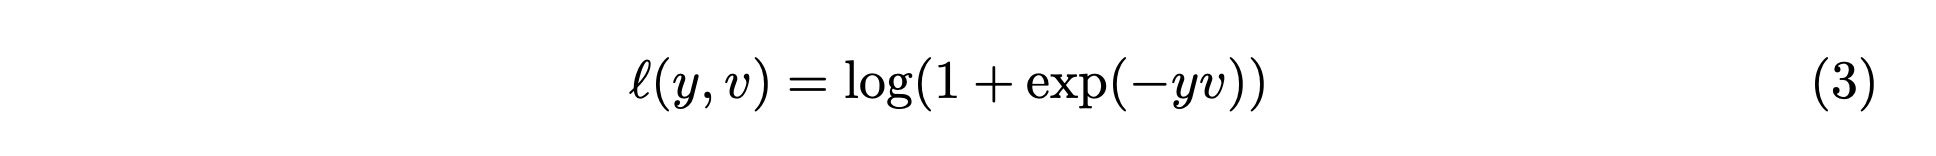

논문 상에서는 이 식의 mean을 loss로서 사용한다고 했는데 여기에서는 그냥 weighted BCELoss를 사용한다.
경험적으로 더 나은 건가 보다.

In [ ]:
class BalancedLoss(nn.Module):

    def __init__(self, neg_weight=1.0):
        super(BalancedLoss, self).__init__()
        self.neg_weight = neg_weight
    
    def forward(self, input, target): # target에서 가운데 부분이 정답이다.
        pos_mask = (target == 1)
        neg_mask = (target == 0)
        pos_num = pos_mask.sum().float()
        neg_num = neg_mask.sum().float()
        weight = target.new_zeros(target.size())
        weight[pos_mask] = 1 / pos_num
        weight[neg_mask] = 1 / neg_num * self.neg_weight # 내가 임의로 정의한 neg_wieght에 따라 neg mask에 weight의 정도를 지정함.
        weight /= weight.sum() # 정규화
        return F.binary_cross_entropy_with_logits(
            input, target, weight, reduction='sum') # 결국 BCELoss
